In [39]:
from collections import Counter
from tqdm import tnrange, tqdm_notebook
from sklearn import preprocessing
import pandas as pd
import numpy as np
from numpy import genfromtxt
import scipy.io
from scipy import stats
from sklearn.feature_extraction import DictVectorizer
import random
import csv
from graphviz import Digraph

In [40]:
# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test,dataname):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(dataname+'submission.csv', index_label='Id')

In [41]:
def viz_tree(r,features):
    stack = []
    g = Digraph()# node_attr={'shape': 'record', 'height': '.1'})
    _id = 0
    current_node = r
    leftward = True
    current_root_num = 0

    while True:
        if current_node:
            stack.append((_id, current_node))
            if current_node.label!= None:
                g.node('node{0}'.format(_id), str(current_node.label))
            else:
                name = features[current_node.feature] + \
                        "<" + str(round(current_node.thresh,2))
                g.node('node{0}'.format(_id), name)
            if _id >= 1:
                g.edge('node{0}:f{1}'.format(current_root_num, \
                                             0 if leftward else 2),
                       'node{0}:f1'.format(_id))

            leftward = True
            current_node = current_node.left  # left
            current_root_num = _id
            _id += 1

        if current_node is None and len(stack)!=0:
            count, popped_node = stack.pop()
            if popped_node.right:
                current_root_num = count
                current_node = popped_node.right  # right
                leftward = False

        if current_node is None and len(stack)==0:
            break      

    return g

In [42]:
class Node:
    def __init__(self, left=None, right=None, label=None,\
                       feature=None,thresh=None):
        self.left = left
        self.right = right
        self.label = label
        self.feature = feature
        self.thresh = thresh
        
class DecisionTree:

    def __init__(self,max_depth = 10):
        self.max_depth = max_depth
        
    def entropy(self,y):
        _, counts = np.unique(y, return_counts=True)
        entropy_ = stats.entropy(counts, base=2)
        return entropy_

    def information_gain(self,y,left,right):

        entropy0 = self.entropy(y)
        Sl = len(left)
        Sr = len(right)
        entropy1 = (Sl * self.entropy(left) + \
                    Sr * self.entropy(right))/(Sl + Sr)

        return entropy0 - entropy1
    
    # split the X and y by idx and thresh
    def split(self,X, y, idx, thresh):
        left_filter = np.where(X[:,idx] < thresh)[0]
        right_filter = np.where(X[:,idx] >= thresh)[0]
        return X[left_filter], y[left_filter], \
               X[right_filter], y[right_filter]
    
    # return the thresh, info_gain
    def findSplitWithIndex(self,X,y,idx):
        mean = []
        col = sorted(np.unique(X[:,idx]))
        
        if len(col)==1:
            mean.append(0)
            
        for i in range(len(col)-1):
            mean.append( (col[i] + col[i+1])/2 )
        
        thresh = mean[0]
        info_ = 0
        for i in mean:
            xl,yl,xr,yr = self.split(X,y,idx,i)
            info_gain = self.information_gain(y,yl,yr)

            if info_gain > info_:
                info_ = info_gain
                thresh = i

        return thresh,info_
        
    # return the idx(figure), thresh 
    def segmenter(self,X, y, m = None):
        info_ = 0
        thresh_ = 0
        idx_ = 0
        
        idxList = np.array(range(X.shape[1]))
        idxList = idxList[np.random.choice(X.shape[1], m,replace=False)]

        for idx in idxList:
            thresh,info_gain = self.findSplitWithIndex(X,y,idx)

            if info_gain > info_:
                info_ = info_gain
                thresh_ = thresh
                idx_ = idx

        return idx_,thresh_
    
    def fit_tree(self,X,y,depth=0,m=None):
        major_label = Counter(y).most_common(1)[0][0]
        if self.entropy(y)==0 or depth == self.max_depth:
            return Node(label=major_label)
        
        idx,thresh = self.segmenter(X,y,m=m)
        xl,yl,xr,yr = self.split(X,y,idx,thresh)
        
        
        if len(yl) > 0 and len(yr) >0:
            left = self.fit_tree(xl,yl,depth+1,m=m)
            right = self.fit_tree(xr,yr,depth+1,m=m)
                
            #label = "(" + idx + ")" + "<" + str(thresh)
            return Node(left,right,label=None,\
                        feature=idx,thresh=thresh)
        else:
            return Node(label=major_label)
    
    def fit(self, X, y,m=None):
        if m == None:
            m = X.shape[1]
        self.header = self.fit_tree(X,y,m=m)

    def predict(self, X):
        node = self.header
        pred = []
        
        for i in range(X.shape[0]):
            while node.label==None:
                if X[i][node.feature] < node.thresh:
                    node = node.left
                else:
                    node = node.right
            pred.append(node.label)
            node = self.header
        return pred
    
    def visualizeTree(self):
        return viz_tree(self.header,features)
        
    # state the splits (i.e., which feature and which value 
    # of that feature to split on) your decision tree made 
    # to classify it.
    def __repr__(self,x,features,class_names):
        node = self.header
        while node.label==None:
            if x[node.feature] < node.thresh:
                print(features[node.feature], "<", node.thresh)
                node = node.left
            else:
                print(features[node.feature], ">", node.thresh)
                node = node.right

        print("Therefore this email was",class_names[node.label])


class RandomForest(DecisionTree):
    
    def __init__(self,B=100,m=6,max_depth = 10):
        self.B = B
        self.m = m
        self.max_depth = max_depth

    def fit(self, X, y):
        self.forest = []
        for i in tqdm_notebook(range(self.B)):
            index = np.random.choice(X.shape[0], X.shape[0] ,\
                                     replace=True)
            X = X[index]
            y = y[index]
            self.forest.append(self.fit_tree(X,y,m=self.m))

    
    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            pred = []
            for j in range(self.B):
                node = self.forest[j]
                while node.label==None:
                    if X[i][node.feature] < node.thresh:
                        node = node.left
                    else:
                        node = node.right
                pred.append(node.label)
            preds.append(Counter(pred).most_common(1)[0][0])
        return preds
        

In [43]:
features = [
        "pain", "private", "bank", "money", "drug", "spam", 
        "prescription", "creative", "height", "featured", 
        "differ", "width", "other", "energy", "business", 
        "message", "volumes", "revision", "path", "meter", 
        "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", 
        "parenthesis", "square_bracket", "ampersand"
    ]
assert len(features) == 32

# Load spam data
path_train = 'datasets/spam-dataset/spam_data.mat'
spamData = scipy.io.loadmat(path_train)
spamX = spamData['training_data']
spamY = np.squeeze(spamData['training_labels'])
spamTest = spamData['test_data']
class_names = ["Ham", "Spam"]

shuffle = np.arange(spamX.shape[0])
np.random.shuffle(shuffle)
spamX = spamX[shuffle]
spamY = spamY[shuffle]

## Decision Tree Spam

In [44]:
classifier = DecisionTree(max_depth = 10)
accu = []
for i in range(5):
    index = np.array(range(int(i*5172/5),int((i+1)*5172/5)))
    
    testX = spamX[index]
    testY = spamY[index]
    
    trainX = np.delete(spamX,index,axis=0)
    trainY = np.delete(spamY,index,axis=0)
    
    classifier.fit(trainX,trainY)
    predictions = classifier.predict(testX)
    predictions = np.array(predictions)
    accu.append(sum(predictions == testY)/testY.size)

In [45]:
np.mean(accu)

0.8203758211158767

In [9]:
classifier.fit(spamX,spamY)
predictions = classifier.predict(spamTest)
predictions = np.array(predictions)

In [10]:
results_to_csv(predictions,"spam")

In [18]:
classifier = DecisionTree(max_depth = 10)
classifier.fit(spamX,spamY)
classifier.__repr__(spamX[1],features,class_names)

exclamation < 0.5
meter < 0.5
parenthesis < 0.5
volumes < 0.5
ampersand < 0.5
pain < 0.5
semicolon > 0.5
dollar > 0.5
out < 0.5
dollar < 2.5
Therefore this email was Spam


In [19]:
classifier.__repr__(spamX[3],features,class_names)

exclamation < 0.5
meter < 0.5
parenthesis > 0.5
dollar < 0.5
money < 0.5
pain < 0.5
featured < 0.5
energy < 0.5
other > 0.5
out < 0.5
Therefore this email was Ham


In [46]:
# Pure depth
index = np.array(range(int(i*5172/5),int((i+1)*5172/5)))

testX = spamX[index]
testY = spamY[index]

trainX = np.delete(spamX,index,axis=0)
trainY = np.delete(spamY,index,axis=0)
accu = []

for i in range(40):
    classifier = DecisionTree(max_depth = i+1)
    
    a = []
    for i in range(5):
        index = np.array(range(int(i*5172/5),int((i+1)*5172/5)))

        testX = spamX[index]
        testY = spamY[index]

        trainX = np.delete(spamX,index,axis=0)
        trainY = np.delete(spamY,index,axis=0)

        classifier.fit(trainX,trainY)
        predictions = classifier.predict(testX)
        predictions = np.array(predictions)
        a.append(sum(predictions == testY)/testY.size)
    accu.append(np.mean(a))

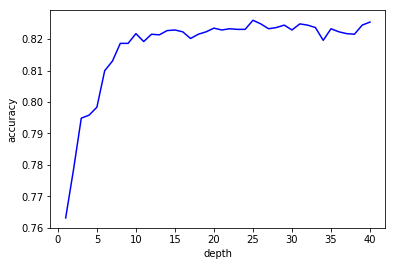

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
depth = list(range(1,41))
plt.plot(depth,accu,c="blue",)
plt.xlabel("depth")
plt.ylabel("accuracy")
plt.show()

## Random Forest Spam

In [91]:
classifier = RandomForest(B=10,m=6,max_depth = 20)
accu = []
for i in range(5):
    index = np.array(range(int(i*5172/5),int((i+1)*5172/5)))
    
    testX = spamX[index]
    testY = spamY[index]
    
    trainX = np.delete(spamX,index,axis=0)
    trainY = np.delete(spamY,index,axis=0)
    
    classifier.fit(trainX,trainY)
    predictions = classifier.predict(testX)
    predictions = np.array(predictions)
    accu.append(sum(predictions == testY)/testY.size)
     

In [92]:
np.mean(accu)

0.8259862267447836

In [53]:
# test
# classifier = RandomForest(B=50,m=6,max_depth = 20)
classifier.fit(spamX, spamY)

In [108]:
# training error
classifier = RandomForest(B=10,m=5,max_depth = 20)
# classifier = DecisionTree(max_depth = 10)
classifier.fit(spamX, spamY)
predictions = classifier.predict(spamX)
predictions = np.array(predictions)
sum(predictions == spamY)/5172

0.8439675174013921

In [109]:
predictions = classifier.predict(spamTest)
predictions = np.array(predictions)
results_to_csv(predictions,"spam")

## titanic data    

In [110]:
 # Load titanic data       
train_data = pd.read_csv("datasets/titanic/titanic_training.csv")
test_data = pd.read_csv("datasets/titanic/titanic_testing_data.csv")

In [111]:
train_data.fillna(train_data.mean(),inplace=True)
test_data.fillna(test_data.mean(),inplace=True)

In [112]:
# one hot for training
train_data = pd.concat([train_data,
                   pd.get_dummies(train_data["sex"], 
                   prefix="sex")],axis=1)
train_data.drop(["sex"], axis=1,inplace=True)

train_data = pd.concat([train_data,
                   pd.get_dummies(train_data["embarked"], 
                   prefix="embarked")],axis=1)
train_data.drop(["embarked"], axis=1,inplace=True)

# one hot for testing
test_data = pd.concat([test_data,
                   pd.get_dummies(test_data["sex"], 
                   prefix="sex")],axis=1)
test_data.drop(["sex"], axis=1,inplace=True)

test_data = pd.concat([test_data,
                   pd.get_dummies(test_data["embarked"], 
                   prefix="embarked")],axis=1)
test_data.drop(["embarked"], axis=1,inplace=True)

In [113]:
train_y = train_data["survived"]
train_data.drop(["survived"], axis=1, inplace=True)

In [114]:
# drop ticket/cabin
train_data.drop(["ticket"], axis=1, inplace=True)
test_data.drop(["ticket"], axis=1, inplace=True)

train_data.drop(["cabin"], axis=1, inplace=True)
test_data.drop(["cabin"], axis=1, inplace=True)


In [115]:
features = list(train_data.columns)

In [116]:
train_data = train_data.values
train_y = train_y.values
test_data = test_data.values

shuffle = np.arange(train_data.shape[0])
np.random.shuffle(shuffle)
train_data = train_data[shuffle]
train_y = train_y[shuffle]

## train_data.shape

In [117]:
classifier = DecisionTree(max_depth=5)
accu = []
for i in range(5):
    index = np.array(range(int(i*1000/5),int((i+1)*1000/5)))
    
    testX = train_data[index]
    testY = train_y[index]
    
    trainX = np.delete(train_data,index,axis=0)
    trainY = np.delete(train_y,index,axis=0)
    
    classifier.fit(trainX,trainY)
    predictions = classifier.predict(testX)
    predictions = np.array(predictions)
    accu.append(sum(predictions == testY)/testY.size)

np.mean(accu)

0.8109999999999999

In [139]:
# pred
classifier = DecisionTree(max_depth=5)
classifier.fit(train_data, train_y)
predictions = classifier.predict(train_data)
predictions = np.array(predictions)
sum(predictions == train_y)/1000

0.83

In [136]:
preds = classifier.predict(test_data)
preds = np.array(preds)
results_to_csv(preds,"tit")

In [132]:
classifier = RandomForest(B=10,m=3,max_depth = 6)
accu = []
for i in range(5):
    index = np.array(range(int(i*1000/5),int((i+1)*1000/5)))
    
    testX = train_data[index]
    testY = train_y[index]
    
    trainX = np.delete(train_data,index,axis=0)
    trainY = np.delete(train_y,index,axis=0)
    
    classifier.fit(trainX,trainY)
    predictions = classifier.predict(testX)
    predictions = np.array(predictions)
    accu.append(sum(predictions == testY)/testY.size)

np.mean(accu)

0.796

In [155]:
# pred
classifier = RandomForest(B=10,m=3,max_depth = 5)
classifier.fit(train_data, train_y)
predictions = classifier.predict(train_data)
predictions = np.array(predictions)
sum(predictions == train_y)/1000

0.814

In [156]:
preds = classifier.predict(test_data)
preds = np.array(preds)
results_to_csv(preds,"tit")

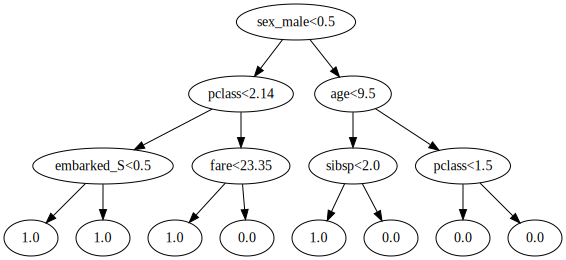

In [38]:
classifier = DecisionTree(max_depth=3)
classifier.fit(train_data, train_y)
classifier.visualizeTree()